<a href="https://colab.research.google.com/github/DeeeTeeee/Sentiment-Classification-FineTunning/blob/main/Fine_tuning_Hugging_face_trainer_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StackOverflow Tag Recommendation Tool with ModernBert 

## Import

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd




In [ ]:
from huggingface_hub import login #,notebook_login()
 
login()

In [3]:
# Load the dataset and display some values
df = pd.read_csv('./QueryResults.csv')


In [4]:
# Check NA
df.isna().sum()

Title                0
Body                 0
Tags                 0
Id                   0
Score                0
ViewCount            0
FavoriteCount    50000
AnswerCount          0
TagCount             0
dtype: int64

In [5]:
# Set the max_colwidth option to a higher value
pd.set_option('display.max_colwidth', None)

In [6]:
# Display the first 5 rows of the dataframe 
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,TagCount
0,How do I execute a program or call a system command?,<p>How do I call an external command within Python as if I had typed it in a shell or command prompt?</p>\n,<python><shell><terminal><subprocess><command>,89228,6240,5053386,NaN,66,5
1,How do I perform an IF...THEN in an SQL SELECT?,"<p>How do I perform an <code>IF...THEN</code> in an <code>SQL SELECT</code> statement?</p>\n\n<p>For example:</p>\n\n<pre><code>SELECT IF(Obsolete = 'N' OR InStock = 'Y' ? 1 : 0) AS Saleable, * FROM Product\n</code></pre>\n",<sql><sql-server><t-sql><if-statement><case>,63447,1804,4726449,NaN,30,5
2,How do I copy a file?,<p>How do I copy a file in Python?</p>\n,<python><file><copy><filesystems><file-copying>,123198,3908,3985117,NaN,21,5
3,"How do I create a directory, and any missing parent directories?","<p>How do I create a directory at a given path, and also create any missing parent directories along that path? For example, the Bash command <code>mkdir -p /path/to/nested/directory</code> does this.</p>\n",<python><exception><path><directory><operating-system>,273192,5780,3934627,NaN,27,5
4,How to return only the Date from a SQL Server DateTime datatype,<pre><code>SELECT GETDATE()\n</code></pre>\n\n<p>Returns: <code>2008-09-22 15:24:13.790</code></p>\n\n<p>I want that date part without the time part: <code>2008-09-22 00:00:00.000</code></p>\n\n<p>How can I get that?</p>\n,<sql><date><t-sql><datetime><sql-server-2008>,113045,2215,3877155,NaN,47,5


## Preprocessing and little EDA

### Data cleaning

In [7]:
# Max Tags Count
print(df.TagCount.max())

6


In [8]:
# Fix the Labels, deliminate
df["Tags"] = df["Tags"].apply(lambda x: x.replace("<",""))
df["Tags"] = df['Tags'].apply(lambda x: x[:-1].split('>')) #[:-1] to skip the last ">"


In [9]:
df = df[["Title","Tags"]]

In [10]:
df.head()

,Title,Tags
0,How do I execute a program or call a system command?,"[python, shell, terminal, subprocess, command]"
1,How do I perform an IF...THEN in an SQL SELECT?,"[sql, sql-server, t-sql, if-statement, case]"
2,How do I copy a file?,"[python, file, copy, filesystems, file-copying]"
3,"How do I create a directory, and any missing parent directories?","[python, exception, path, directory, operating-system]"
4,How to return only the Date from a SQL Server DateTime datatype,"[sql, date, t-sql, datetime, sql-server-2008]"


In [11]:
# Count of Individula Tags
Tags = df['Tags'].explode().value_counts()# value_counts returns in descending order
print(Tags)

# All tags are in lower case so no further processing is required for the moment

Tags
javascript                  6795
java                        5716
python                      5302
c#                          5298
html                        3302
                            ... 
kubernetes-networkpolicy       1
iso-3166                       1
uint8t                         1
git-extensions                 1
skype4com                      1
Name: count, Length: 19484, dtype: int64


<Axes: >

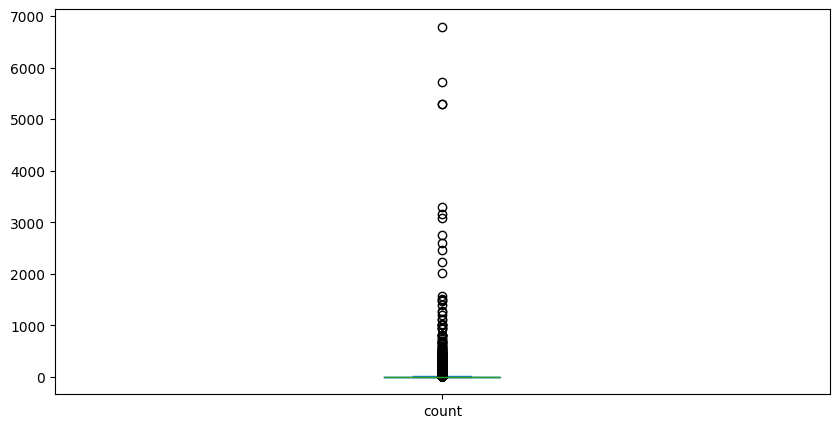

In [12]:
# Quick Plot
Tags.plot(kind='box', figsize=(10,5))

Mean and Median is close to 1 and top ~20 tags are used in at least 5% of the questions. To reduce the complexity of this task, top 30 tags are thus selected. 

### Class Preprocessing

In [13]:
classes = Tags.head(30).index.tolist() # select top 30 tags 
class2id = {clas: id for id, clas in enumerate(classes)}
id2class = {id: clas for clas, id in class2id.items()}
print(class2id)
print(len(class2id))
print(id2class)
print(len(id2class))

{'javascript': 0, 'java': 1, 'python': 2, 'c#': 3, 'html': 4, 'php': 5, 'android': 6, 'jquery': 7, 'ios': 8, 'c++': 9, '.net': 10, 'css': 11, 'node.js': 12, 'sql': 13, 'asp.net': 14, 'arrays': 15, 'mysql': 16, 'json': 17, 'reactjs': 18, 'c': 19, 'objective-c': 20, 'swift': 21, 'python-3.x': 22, 'linux': 23, 'spring': 24, 'iphone': 25, 'ajax': 26, 'database': 27, 'sql-server': 28, 'ruby-on-rails': 29}
30
{0: 'javascript', 1: 'java', 2: 'python', 3: 'c#', 4: 'html', 5: 'php', 6: 'android', 7: 'jquery', 8: 'ios', 9: 'c++', 10: '.net', 11: 'css', 12: 'node.js', 13: 'sql', 14: 'asp.net', 15: 'arrays', 16: 'mysql', 17: 'json', 18: 'reactjs', 19: 'c', 20: 'objective-c', 21: 'swift', 22: 'python-3.x', 23: 'linux', 24: 'spring', 25: 'iphone', 26: 'ajax', 27: 'database', 28: 'sql-server', 29: 'ruby-on-rails'}
30


In [14]:
# Update the Tags col with the top 30 tags
df['Tags'] = df['Tags'].apply(
    lambda x: list(set([tag if tag in classes else 'other/none' for tag in x ]))
    )

In [15]:
df['Tags'].value_counts()

Tags
[other/none]                                        9608
[other/none, python]                                3660
[java, other/none]                                  3122
[other/none, c#]                                    2321
[other/none, c++]                                   1749
                                                    ... 
[swift, c, objective-c, other/none]                    1
[android, json, other/none, c#, arrays]                1
[java, sql, sql-server, mysql, other/none]             1
[java, spring, other/none, jquery, javascript]         1
[json, other/none, javascript, python-3.x, html]       1
Name: count, Length: 1296, dtype: int64

In [16]:
# add 'none/other' into classes
classes.append('other/none')
class2id['other/none'] = len(class2id)    
id2class[len(id2class)] = 'other/none'

In [17]:
print(len(classes))
print(class2id)
print(len(class2id))
print(id2class)
print(len(id2class))

31
{'javascript': 0, 'java': 1, 'python': 2, 'c#': 3, 'html': 4, 'php': 5, 'android': 6, 'jquery': 7, 'ios': 8, 'c++': 9, '.net': 10, 'css': 11, 'node.js': 12, 'sql': 13, 'asp.net': 14, 'arrays': 15, 'mysql': 16, 'json': 17, 'reactjs': 18, 'c': 19, 'objective-c': 20, 'swift': 21, 'python-3.x': 22, 'linux': 23, 'spring': 24, 'iphone': 25, 'ajax': 26, 'database': 27, 'sql-server': 28, 'ruby-on-rails': 29, 'other/none': 30}
31
{0: 'javascript', 1: 'java', 2: 'python', 3: 'c#', 4: 'html', 5: 'php', 6: 'android', 7: 'jquery', 8: 'ios', 9: 'c++', 10: '.net', 11: 'css', 12: 'node.js', 13: 'sql', 14: 'asp.net', 15: 'arrays', 16: 'mysql', 17: 'json', 18: 'reactjs', 19: 'c', 20: 'objective-c', 21: 'swift', 22: 'python-3.x', 23: 'linux', 24: 'spring', 25: 'iphone', 26: 'ajax', 27: 'database', 28: 'sql-server', 29: 'ruby-on-rails', 30: 'other/none'}
31


### Title Preprocessing

In [19]:
# Convert title to lower case
df['Title'] = df['Title'].str.lower()
print(df['Title'])

0                                                   how do i execute a program or call a system command?
1                                                        how do i perform an if...then in an sql select?
2                                                                                  how do i copy a file?
3                                       how do i create a directory, and any missing parent directories?
4                                        how to return only the date from a sql server datetime datatype
                                                      ...                                               
49995    my javascript variable not able to accept object which i have send using django render() method
49996       linkers: file was built for archive which is not the architecture being linked (x86_64) glfw
49997                                                          generating a lot of unique tokens in ruby
49998                                 javascript: multi

## Model setups

In [20]:
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer


In [21]:

model_id = "bert-base-uncased" #"answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
# Convert Pandas DataFrame to Hugging Face Dataset
from datasets import Dataset
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['Title', 'Tags'],
    num_rows: 50000
})

In [23]:
# Tokenisation
def preprocess_function(example):
   text = example['Title']
   all_labels = example['Tags']
   labels = [0. for i in range(len(classes))]
   for label in all_labels:
       label_id = class2id[label]
       labels[label_id] = 1.
  
   example = tokenizer(text, truncation=True) # padding="max_length" if no dynamic padding
   example['labels'] = labels
   return example

tokenized_dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [24]:
# Shuffle and Split the dataset
tokenized_dataset = tokenized_dataset.shuffle(seed=42).train_test_split(test_size=0.3)

In [25]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['Title', 'Tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
})

In [26]:
# Collator for Dynamic Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=len(classes),id2label=id2class, label2id=class2id,problem_type = "multi_label_classification"
    )
#model.to_device()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Eval Function Setup
import evaluate
import numpy as np

clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [31]:
training_args = TrainingArguments(

   output_dir="stackoverflow_tagger_bert",
   learning_rate=2e-5,
   per_device_train_batch_size=3,
   per_device_eval_batch_size=3,
   num_train_epochs=1, # ideally 3-5 epoches but for the limitation of infrastructure, I am using 1 epoch
   weight_decay=0.01,
   evaluation_strategy="epoch",
   save_strategy="epoch",
   load_best_model_at_end=True,
)

trainer = Trainer(

   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

trainer.train()

/var/folders/nr/sl56fw5d2851zlfqbbqghrhm0000gn/T/ipykernel_8803/1473997891.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.103200,0.098023,0.968748,0.759833,0.893779,0.660803


TrainOutput(global_step=11667, training_loss=0.11666633100469591, metrics={'train_runtime': 18093.9356, 'train_samples_per_second': 1.934, 'train_steps_per_second': 0.645, 'total_flos': 376807340802816.0, 'train_loss': 0.11666633100469591, 'epoch': 1.0})

In [36]:
# Publish the model to Hugging Face Hub
trainer.push_to_hub("stackoverflow_tagger_bert")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eugeneskchan/stackoverflow_tagger_bert/commit/3291dde77afb2e5009ad249641fdabed3aded801', commit_message='stackoverflow_tagger_bert', commit_description='', oid='3291dde77afb2e5009ad249641fdabed3aded801', pr_url=None, repo_url=RepoUrl('https://huggingface.co/eugeneskchan/stackoverflow_tagger_bert', endpoint='https://huggingface.co', repo_type='model', repo_id='eugeneskchan/stackoverflow_tagger_bert'), pr_revision=None, pr_num=None)

In [53]:
from transformers import pipeline
clf = pipeline("text-classification",model="eugeneskchan/stackoverflow_tagger_bert")

Device set to use cpu


In [65]:
result = clf("how do i install python on linux", top_k=6)
output = [r['label'] for r in result if r['score'] > 0.8]
print(output)

['other/none', 'python']
